<a href="https://colab.research.google.com/github/OrJaku/road-sign-recognition/blob/master/road_sign_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instrukcja działania aplikacji uczenia oraz rozpoznawania znaków 

#####1. Plik *road_sign_rec_model.ipynb* środowkiska Google Colab (Jupiter Notebook) zawiera biblioteki potrzebne do zbidowania sieci neuronowej
#####2. W pliku nalezy zaimportować biblioteki oraz skopiować i rozpakować zbiór wcześniej przygotowanych znaków
######a. Do przygotowania plików (obrazów) potrzebnych do nauki sieci, służy aplikacja *property_app* napisana w lokalnym środkowski python
######b. Po uruchmieniu aplikacji (przez plik *run_property.py*) otrzymujemy menu wyboru:
    1 - Znajdź wybrane zdjęcia ze znakami lub wygeneruj listę etykiet <pliki sprawdzane w folderze */annotations* - z plikami JSON, plik CSV z listą wybranych plików zapisywany jest w folderze z aplikacją *property_app/output*'>
    2 - Kopiuj wybrane zdjęcia do nowego katalogu <kopiowanie plików (wybranych i dodanych wcześniej do pliku csv - konkretnego znaku), do nowej lokalizacji (np. pamięć flash lub dysk lokalny)
    3 - Wytnij znaki z pełnych zdjęć <wycinanie znaków z lokalizacji z pkt 2 do lokalnego folderu */home/kuba-ubuntu/img_mgr_out*>
    4 - Kopiuj wycięte zdjęcia do katalogów (train/valid/test) <kopiwanie wyciętych zdjęć do datasetów w lokalizacji '/home/kuba-ubuntu/Pobrane/Data' >
    9 - Dostępne znaki
    0 - Koniec

######c. Opcja 1. umożliwia wygenerowanie pliku CSV z nazwami obrazów zawierającymi wybrane przez nas znaki w pliku *run_property.py* w tabeli 'labels_list':
    labels_list = [ 
    "regulatory--keep-left--g1",
    "regulatory--keep-right--g2",
    "complementary--keep-right--g1",
    "regulatory--keep-left--g2",
    "regulatory--keep-right--g1",
    "complementary--keep-left--g1",
    "regulatory--yield--g1"]



##Biblioteki

In [ ]:
import os, shutil, cv2, json
import pandas as pd
import numpy as np
from keras import layers, models, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import time


## Pliki

### Kopiowanie obrazów treningowych na dysk Colab

In [ ]:
cd "/content"

/content


In [ ]:
try:
  os.mkdir("data")
except FileExistsError:
  pass
!cp "/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Temp/Dataset_extend_zip.zip" "/content/data/Dataset_extend_zip.zip"

In [ ]:
cd data

/content/data


In [ ]:
!unzip -q Dataset_extend_zip.zip

In [ ]:
data_folder = "/content/data/Data"
train_folder = os.path.join(data_folder, 'train_data')
signs_list_train = os.listdir(train_folder)
train_folders_length = {}
for signs_train in signs_list_train:
  train_folders_length[signs_train] = len(os.listdir(os.path.join(train_folder, signs_train)))
print(train_folders_length)
valid_folder = os.path.join(data_folder, 'valid_data')
signs_list_valid = os.listdir(valid_folder)
valid_folders_length = {}
for signs_val in signs_list_valid:
  valid_folders_length[signs_val] = len(os.listdir(os.path.join(valid_folder, signs_val)))
print(valid_folders_length)

{'nosign': 6036, 'yield': 1665, 'cross': 1326, 'limit60': 1144, 'stop': 1314, 'limit50': 1606, 'limit40': 586, 'no-overtaking': 367, 'othersign': 921, 'limit70': 1264, 'limit80': 1236}
{'nosign': 2575, 'yield': 832, 'cross': 663, 'limit60': 573, 'stop': 506, 'limit50': 803, 'limit40': 294, 'no-overtaking': 184, 'othersign': 461, 'limit70': 633, 'limit80': 618}


### Przygotowanie folderów

In [ ]:
base_dir = "Data/"

train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass
test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass
valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

##Modele

###Przygotowanie parametrów

####Ustawienia genereatora zdjęć

In [ ]:
batch_size = 64
picture_size = 96
class_mode = "categorical"

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,                                   
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode

)
number_of_classes = len(train_generator.class_indices)

Found 17465 images belonging to 11 classes.
Found 8142 images belonging to 11 classes.


####Parametry modelu

In [ ]:
INIT_LR = 1e-3
epochs = 110
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)
metrics = 'categorical_accuracy'
activation = 'softmax'
loss = 'categorical_crossentropy'

###Model multi-classes classification - własny

In [ ]:
dropout_1 = 0.4
dropout_2 = 0.3
dropout_3 = 0.3
dropout_4 = 0.4
dropout_5 = 0.3
dropout_6 = 0.25

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_4))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_6))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))

model.compile(
    loss=loss,
    optimizer=opt,
    metrics=[metrics]
    )
# model.summary()

###Pretrained model

In [ ]:
from keras.applications import VGG16
pretrain_model = VGG16(weights='imagenet',include_top=False,input_shape=(100, 100, 3))

In [ ]:
model = models.Sequential()
model.add(pretrain_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
    )
model.summary()

###Fit model

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=50
)

time_stemp = time.strftime("%d%m%Y%H%M%S")
model_name = f'model_signs_{number_of_classes}_classes_{activation}_{time_stemp}.h5'
path_to_save = "/content/drive/My Drive/Colab Notebooks/Road_sign_rec"
model_path = os.path.join(path_to_save, model_name)
model.save(model_path)
print(f"Saved model as {model_name}")

###Sprawdzenie modelu

####Przebieg uczenia 


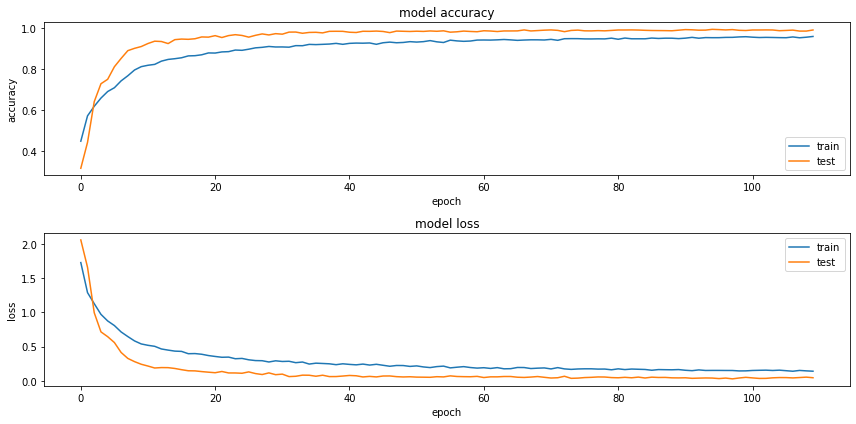

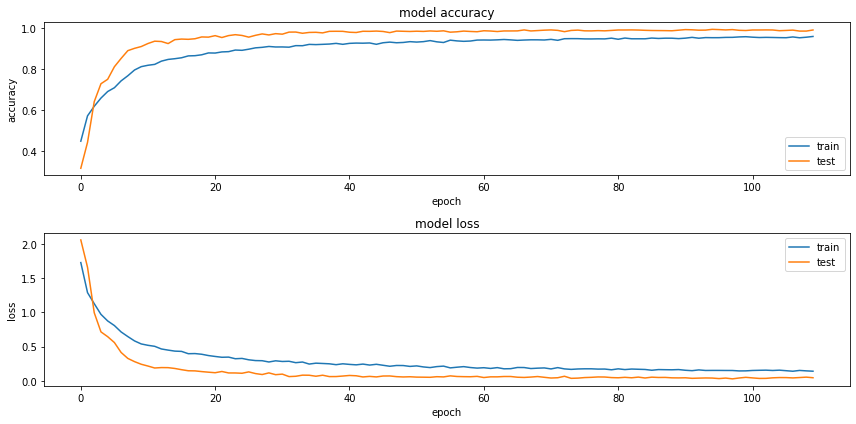

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

####Testowanie modelu

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1,
        )

filenames = test_generator.filenames
classes_gen = test_generator.class_indices
classes_gen = test_generator.class_indices

loss_acc = model.evaluate(test_generator)
print(classes_gen)
print('loss= ', loss_acc[0])
print("acc= ", loss_acc[1])

Found 3492 images belonging to 11 classes.
3492/3492 [==============================] - 10s 3ms/step - loss: 0.0433 - categorical_accuracy: 0.9871
{'cross': 0, 'limit40': 1, 'limit50': 2, 'limit60': 3, 'limit70': 4, 'limit80': 5, 'no-overtaking': 6, 'nosign': 7, 'othersign': 8, 'stop': 9, 'yield': 10}
loss=  0.04329412057995796
acc=  0.9871134161949158


In [ ]:
predict = model.predict_generator(test_generator,steps = len(filenames))

Instructions for updating:
Please use Model.predict, which supports generators.


array([[9.9992919e-01, 7.5319576e-08, 4.5327280e-07, ..., 6.6899838e-06,
        1.1244091e-06, 2.0636246e-06],
       [9.9994814e-01, 1.4976727e-07, 1.8161695e-06, ..., 1.4412996e-05,
        4.2483236e-07, 2.1302865e-06],
       [9.9998498e-01, 2.7772771e-08, 2.1378148e-07, ..., 2.3433724e-06,
        1.2861167e-07, 3.9950041e-07],
       ...,
       [1.1605798e-12, 7.1934633e-12, 1.2611884e-10, ..., 2.7717065e-10,
        6.9089498e-11, 1.0000000e+00],
       [1.6743096e-08, 2.2373221e-08, 1.1110036e-06, ..., 3.7213212e-07,
        8.2686563e-07, 9.9997067e-01],
       [3.4634781e-11, 6.4018491e-10, 5.8945022e-09, ..., 4.8383382e-09,
        1.8866355e-09, 9.9999976e-01]], dtype=float32)

In [ ]:
from google.colab.patches import cv2_imshow

signs = test_generator.class_indices
prediction_list = []
memo_correct_percent = {}
for sign in signs:
  files = os.path.join(test_dir, sign)
  test_files = os.listdir(files)
  incorrect = 0
  for f in test_files:
    path_to_test = os.path.join(files, f)
    img = cv2.imread(path_to_test)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb,(picture_size,picture_size))
    img_resized_float = img_resized.astype("float32") / 255
    img_tensor = np.reshape(img_resized_float,[1,picture_size,picture_size,3])
    classes = (model.predict_classes(img_tensor)).tolist()
    for num, class_ in enumerate(signs):
      if classes[0] == num:
        classes = list(signs.keys())[list(signs.values()).index(num)]
    else:
      classes
    if classes != sign:
      # cv2_imshow(img)
      incorrect += 1 
  corrent_percent = round(100-(incorrect/len(test_files)*100))
  memo_correct_percent[sign] = corrent_percent
  prediction_note = f'{sign}: {incorrect} / {len(test_files)},  Poprawność: {corrent_percent}%'
  prediction_list.append(prediction_note)
  print(prediction_note)
mean_correct_percent = round(sum(memo_correct_percent.values()) / len(signs), 1)
print(f'Średnia poprawność predykcji: {mean_correct_percent}%')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
cross: 0 / 409,  Poprawność: 100%
limit40: 3 / 98,  Poprawność: 97%
limit50: 6 / 312,  Poprawność: 98%
limit60: 4 / 191,  Poprawność: 98%
limit70: 2 / 211,  Poprawność: 99%
limit80: 7 / 206,  Poprawność: 97%
no-overtaking: 3 / 62,  Poprawność: 95%
nosign: 14 / 1334,  Poprawność: 99%
othersign: 4 / 155,  Poprawność: 97%
stop: 5 / 236,  Poprawność: 98%
yield: 5 / 278,  Poprawność: 98%
Średnia poprawność predykcji: 97.8%


###Zapis danych modelu i wyników do pliku tekstowego

In [ ]:
time_date = time.strftime("%d/%m/%Y - %H:%M:%S")
with open("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Log_data.txt", "a") as f:
  f.write(f"Model {time_date} \n")
  f.write(f"Funkcja aktywacji: {activation} \n")
  f.write(f"Liczba klas: {len(classes_gen)}\n")
  f.write(f"Ilość zdjęć treningowych: \n")
  for key, value in train_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Ilość zdjęć walidacyjnych: \n")
  for key, value in valid_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Parametry:\n \tEpochs: {epochs}\n \tMetrics: {metrics}\n \tLoss: {loss}\n \tClassification: {class_mode} \n")
  f.write(f"\tBatch size: {batch_size}\n")
  f.write(f"\tWielkość zdjęć: {picture_size}x{picture_size}px\n")
  f.write(f"\tIlość warstw modelu: {len(model.layers)}\n")
  f.write(f"\tDropout: 1 - {dropout_1}; 2 - {dropout_2}; 3 - {dropout_3}; 4 - {dropout_4}; 5 - {dropout_5}; 6 - {dropout_6}\n")
  f.write("\n")
  f.write("Wyniki: \n")
  f.write(f"\tSTRATA [loss]: {loss_acc[0]}\n")
  f.write(f"\tDOKŁADNOŚĆ [acc]: {loss_acc[1]}\n")
  f.write(f"\tIlość zdjęć testowych: {len(test_generator.filenames)}\n")
  for prediction in prediction_list:
    f.write(f"\t{prediction}\n")
  f.write(f"Średnia poprawność manualnej predykcji: {mean_correct_percent}% \n")
  f.write(f"Nazwa pliku: {model_name}")
  f.write("\n")
  f.write("-------------------------------------------------------------")
  f.write("\n\n")

###Zapis modelu (.json) i wag (.h5)

In [ ]:
model_name_json = f'model_{len(classes_gen)}conv.json'
model_path = os.path.join("/content/drive/My Drive/Colab Notebooks/Road_sign_rec", model_name_json)
json_config = model.to_json()
with open(model_path, 'w') as json_file:
    json_file.write(json_config)

In [ ]:
model_name = 'model_signs_4_multi_classes_sigmoid.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Road_sign_rec/model_signs_9_classe_sigmoid_23052020.h5')

In [ ]:
figure = plt.figure()
files = os.path.join(test_dir, 'cross')
test_files = os.listdir(files)
path_to_test = os.path.join(files, test_files[100])
img = cv2.imread(path_to_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(picture_size,picture_size))
plt.imshow(img)
plt.show()

##Detekcja wideo

###Pliki i ścieżki

In [ ]:
video_path_input_directory = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input'
video_file_name = 'warsaw_drive_test.mp4'
video_path_file = os.path.join(video_path_input_directory, video_file_name)
video_path_output = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Output'
print(video_path_file)
from google.colab.patches import cv2_imshow

/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input/warsaw_drive_test.mp4


In [ ]:
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  cap = cv2.VideoCapture(video_path_file)
  video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap_video_fps = int(cap.get(cv2.CAP_PROP_FPS))
  cap_video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  cap_video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  print("FPS", cap_video_fps)
  print("Length", video_length)
  writer = None
  (W, H) = (None, None)
  mean = np.array([100, 100, 100], dtype="float32")
  i = 0
  while True:
      i += 1
      print(f'{i} / {video_length}')
      (grabbed, frame) = cap.read()
      if not grabbed:
          break
      if W is None or H is None:
          (H, W) = frame.shape[:2]
      output = frame.copy()
      ss.setBaseImage(output)
      try:
        ss.switchToSelectiveSearchFast()
      except cv2.error:
        break
      ssresults = ss.process()
      for w, result in enumerate(ssresults):
          if w < 2000:
              x, y, w, h = result
              timage = output[y:y+h, x:x+w]
              resized = cv2.resize(timage, (100, 100), interpolation=cv2.INTER_AREA)
              resized = resized - mean
              img = np.expand_dims(resized, axis=0)
              out = model.predict(img/255.0, batch_size=10)
              if out[0][0] >= 0.99:
                  cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
      if writer is None:
          fourcc = cv2.VideoWriter_fourcc(*"MJPG")
          writer = cv2.VideoWriter('Output/out_video.mp4', 
                                   fourcc, 
                                   30,
                                   (W, H), 
                                   True,
                                   )
      writer.write(output)
      cv2_imshow(output)
  print("__END__")